# How to select movies with all actors in as few movies as possible

It sometimes can feel overwhelming how many movies one has to watch to build a strong cinematographic culture. In 1999, the American Film Institute (AFI) defined a [list of 50 Hollywood legends](https://www.afi.com/afis-100-years-100-stars/) of the classical Hollywood era. While some of the actors in this list starred in multiple movies that would actually need to be seen, is it possible to define a strategy to cover all of these actors by watching as few movies as possible? 

This problem is actually known as the Set Cover problem. This problem attempts to find the smallest collection of sets which would cover the whole universe. Reformulated for our purpose, it is finding the smallest list of movies which would cover all the actors listed by the AFI.

The Set Cover problem is one of the fundamental algorithmic problems and has been shown to be NP-complete, meaning there is no known way to find a solution for this problem in an efficient way. Therefore, we will be using two approximation approaches to solve this problem: the greedy algorithm and an integer programming approximation.



## 1. Loading the data

In [1]:
from scipy.optimize import linprog
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import itertools

Below is the list of legend actors and actresses as defined by the American Film Institute.

In [2]:
afi_female_legends = [
              "Katharine Hepburn", "Bette Davis", "Audrey Hepburn", "Ingrid Bergman",
              "Greta Garbo", "Marilyn Monroe", "Elizabeth Taylor", "Judy Garland",
              "Marlene Dietrich", "Joan Crawford", "Barbara Stanwyck", "Claudette Colbert",
              "Grace Kelly", "Ginger Rogers", "Mae West", "Vivien Leigh",
              "Lillian Gish", "Shirley Temple", "Rita Hayworth", "Lauren Bacall", 
              "Sophia Loren", "Jean Harlow", "Carole Lombard", "Mary Pickford",
              "Ava Gardner"
]
afi_male_legends = [
                    "Humphrey Bogart", "Cary Grant", "James Stewart", "Marlon Brando",
                    "Fred Astaire", "Henry Fonda", "Clark Gable", "James Cagney",
                    "Spencer Tracy", "Charles Chaplin", "Gary Cooper", "Gregory Peck",
                    "John Wayne", "Laurence Olivier", "Gene Kelly", "Orson Welles",
                    "Kirk Douglas", "James Dean", "Burt Lancaster", "Groucho Marx",
                    "Buster Keaton", "Sidney Poitier", "Robert Mitchum", "Edward G. Robinson",
                    "William Holden"
]

legend_actors = afi_female_legends + afi_male_legends

The data comes from IMDB and links each actor to the movies it starred in.

In [3]:
%%capture
! wget "https://datasets.imdbws.com/title.principals.tsv.gz"
! wget "https://datasets.imdbws.com/title.basics.tsv.gz"
! wget "https://datasets.imdbws.com/name.basics.tsv.gz"

! gunzip title.principals.tsv.gz
! gunzip title.basics.tsv.gz
! gunzip name.basics.tsv.gz

In [4]:
cast = pd.read_csv("title.principals.tsv", sep="\t", na_values="\\N", keep_default_na=False, 
                   usecols=["tconst", "nconst", "category", "job"],
                   dtype={"tconst": str, "nconst": str, "category": str, "job": str})
titles = pd.read_csv("title.basics.tsv", sep="\t", na_values="\\N", keep_default_na=False,
                     usecols=["tconst", "primaryTitle", "startYear", "titleType"],
                    dtype={"tconst": str, "primaryTitle": str, "startYear": "Int64","titleType":str})
names = pd.read_csv("name.basics.tsv", sep="\t", na_values="\\N", keep_default_na=False,
                    usecols=["nconst", "primaryName"],
                   dtype={"nconst": str, "primaryName": str})

In [5]:
movie_titles = titles[titles.titleType == "movie"]

In [6]:
set_movies = pd.merge(
    pd.merge(
        names[names.primaryName.isin(legend_actors)],
        cast[cast.category.isin(["actor", "actress"])],
        on="nconst"
        ),
    titles[(titles.titleType == "movie") & (titles.startYear.notna())],
     on="tconst"
     )

In [7]:
print("All these actors have played in %i movies over their careers." %len(set_movies[["primaryTitle", "startYear"]].drop_duplicates()))

All these actors have played in 2258 movies over their careers.


Note that this does not cover absolutely all the movies these actors starred in, since IMDB only gives the first 3 or 4 main names from the end credits. This means that smaller cameo roles are not included in this analysis.

## 2. Exploration

As a first step, we can then check how many different actors each member of our list starred with. 

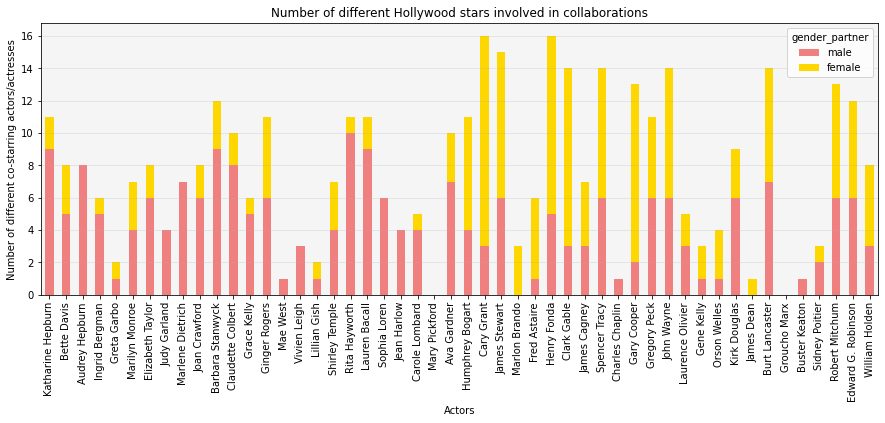

In [8]:
def plot_collaborations(aggregator, title, y_label, set_movies, legend_actors):
    count_collaborations = set_movies.copy()
    count_collaborations["gender"] = count_collaborations.primaryName.apply(
        lambda x: "male" if x in afi_male_legends else "female"
        )
    count_collaborations = pd.merge(count_collaborations, count_collaborations, on=["primaryTitle", "startYear"], suffixes=[None, "_partner"])
    count_collaborations = count_collaborations[count_collaborations.primaryName != count_collaborations.primaryName_partner]

    counts = (count_collaborations
            .groupby(["primaryName", "gender_partner"], as_index=False)
            .agg({"primaryName_partner": aggregator})
            .merge(pd.DataFrame({"primaryName": legend_actors}), how="right")
            .pivot(index="primaryName", columns="gender_partner", values="primaryName_partner")
            .fillna(0)
            .loc[legend_actors, ["male", "female"]]
    )

    fig, ax = plt.subplots(figsize=(15,5))
    counts.plot.bar(stacked=True, ax=ax, color={"male": "lightcoral", "female": "gold"})
    ax.grid(axis="y", alpha=0.3)
    ax.set(
        title=title,
        xlabel="Actors",
        ylabel=y_label,
        facecolor="whitesmoke"
        )
    plt.show()

plot_collaborations("nunique",
                    "Number of different Hollywood stars involved in collaborations", 
                    "Number of different co-starring actors/actresses",
                    set_movies,
                    legend_actors)

Based on this chart, we can see that the two actors who played with most other actors Cary Grant and Henry Fonda with 16 different co-starring partners of the list. One clear trend that is visible from this chart is that these actresses rarely played with other actresses, while it is more common for male actors to share a movie with another leading actor. Finally, this shows that two members of this list do not share any movie with anyone else: Mary Pickford and Groucho Marx. For the former, it is mostly because she was active in the very early days of Hollywood, for the latter because he specialised in a distinctive kind of comedies.

We can then explore things one level further by looking at exactly what actor played with whom. This can be visualised as a graph where actors are represented by nodes and common movies are represented by an edge connecting them. Below, we show these graphs within both groups of male and female Hollywood legends. 

In [9]:
def plot_graph(actor_list, movies, title):
    movies = movies[movies.primaryName.isin(actor_list)]
    combinations = movies[movies.groupby(["primaryTitle", "startYear"]).primaryName.transform("count") > 1]
    G=nx.Graph()
    G.add_nodes_from(actor_list)
    actor_pairs = []
    for movie in combinations.primaryTitle.unique():
        actors = list(combinations[combinations.primaryTitle == movie].primaryName)
        actor_pairs += list(itertools.combinations(actors, 2))
    G.add_edges_from(actor_pairs)

    fig, ax = plt.subplots(figsize=(15,15))
    nx.draw(G, with_labels=True, pos=nx.shell_layout(G), ax=ax, node_color="powderblue", edge_color="grey") 
    ax.axis([-1.2, 1.2, -1.2, 1.2])
    ax.set_title(title)

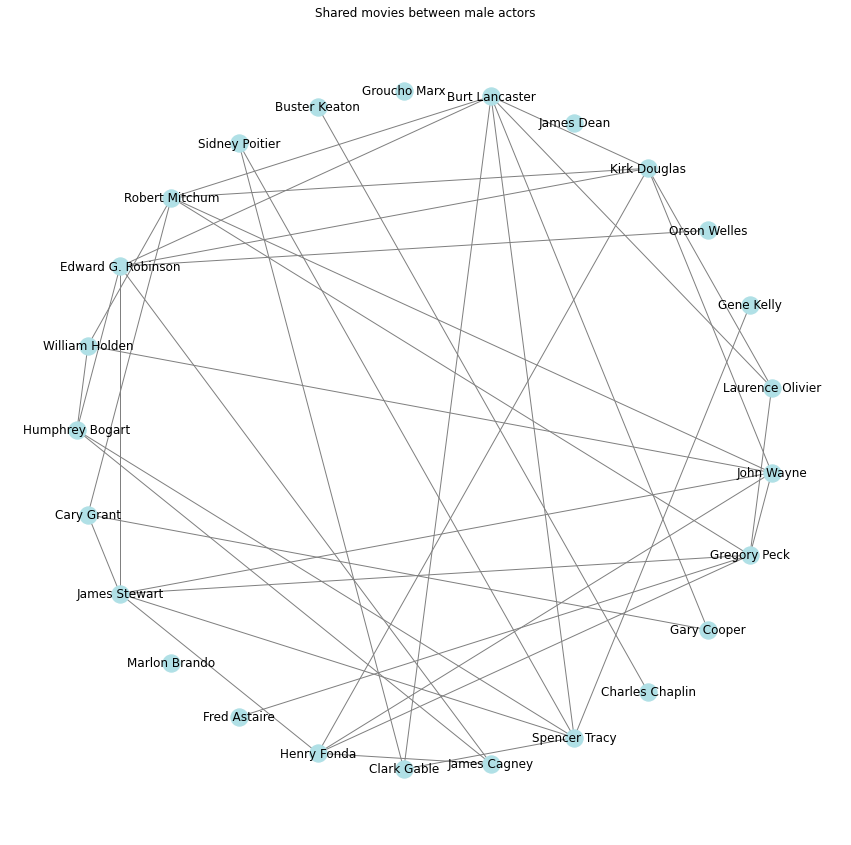

In [10]:
plot_graph(afi_male_legends, set_movies, "Shared movies between male actors")

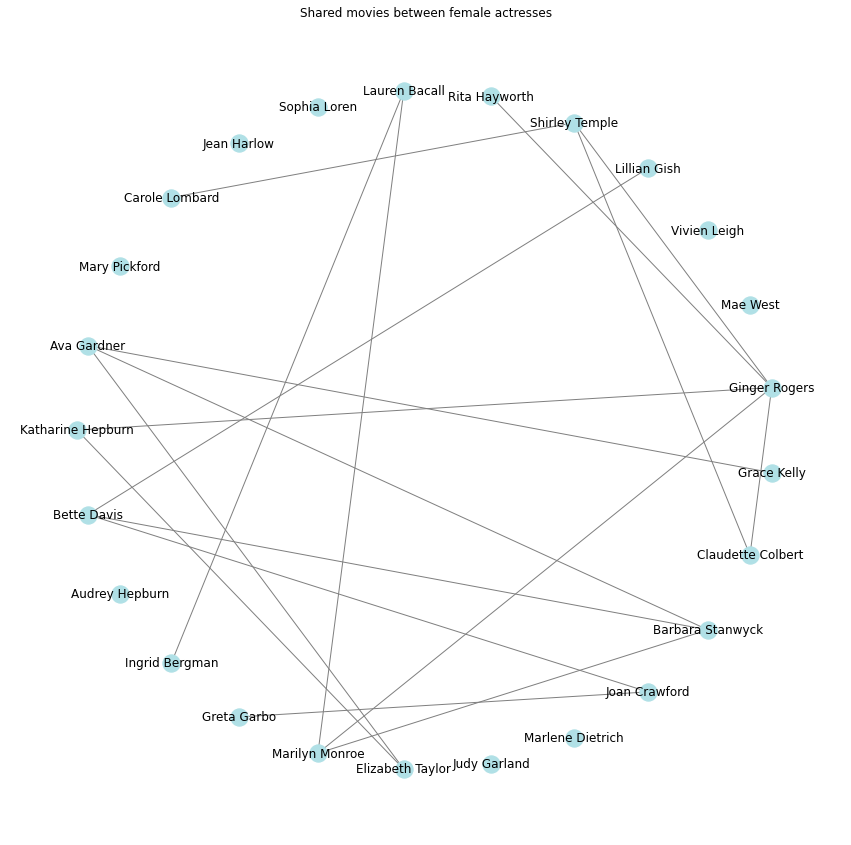

In [11]:
plot_graph(afi_female_legends, set_movies, "Shared movies between female actresses")

This again illustrates quite clearly that lead actresses shared way less movies together than lead actors. The actor who starred with most other male actors is Burt Lancaster (7), the actress who starred with most other female actresses is Ginger Rogers (5).

## 3. Data Preparation

As mentioned above, these actors and actresses played in 2257 movies in total. This can be simplified for our purpose quite dramatically by keeping only the movies where multiple actors appear in the credits. As we have shown above, only Mary Pickford and Groucho Marx would be left out as a result. For them, there is no other option than picking one of their films individually to complete the list. 

This simplification will reduce computation time without changing anything to the solution of the problem.

In [12]:
combinations = set_movies[set_movies.groupby(["primaryTitle", "startYear"]).primaryName.transform("count") > 1]
one_each = set_movies[~set_movies.primaryName.isin(combinations.primaryName)].groupby("primaryName", as_index=False).first()
set_movies = pd.concat([combinations, one_each])
set_movies = set_movies.drop_duplicates(["primaryName", "category", "primaryTitle", "startYear"])
set_movies.head()

,nconst,primaryName,tconst,category,job,titleType,primaryTitle,startYear
0,nm0000001,Fred Astaire,tt0025164,actor,NaN,movie,The Gay Divorcee,1934
1,nm0001677,Ginger Rogers,tt0025164,actress,NaN,movie,The Gay Divorcee,1934
2,nm0000001,Fred Astaire,tt0026942,actor,NaN,movie,Roberta,1935
3,nm0001677,Ginger Rogers,tt0026942,actress,NaN,movie,Roberta,1935
4,nm0000001,Fred Astaire,tt0027125,actor,NaN,movie,Top Hat,1935


In [13]:
print("We are considering %i movies for this problem by keeping only the movies shared by multiple actors." 
      %len(set_movies[["primaryTitle", "startYear"]].drop_duplicates()))

We are considering 261 movies for this problem by keeping only the movies shared by multiple actors.


## 4. Greedy Algorithm

The first algorithm we can use to approximate a solution to this set cover problem is the greedy algorithm. The way it works is very easy: it iteratively selects the movie that covers the largest number of actors left. The algorithm then continues until each actor has been selected. The solution may not be optimal because the greedy algorithm is "short-sighted", it may select a movie first that covers most actors at once, but that then discards more interesting combinations further on. 

In [14]:
def greedy_cover(movies):
    selected_movies = []
    selected_years = []
    while not movies.empty:
        title, year = movies.groupby(["primaryTitle", "startYear"]).primaryName.count().idxmax()
        selected_movies.append(title)
        selected_years.append(year)
        actors_selected = movies[(movies.primaryTitle == title) & (movies.startYear == year)].primaryName
        movies = movies[~movies.primaryName.isin(actors_selected)]
    min_set = pd.DataFrame({"title": selected_movies, "year": selected_years})
    return min_set

In [15]:
greedy_min_set = greedy_cover(set_movies)
print("The greedy algorithm returned a min set of length %i." %len(greedy_min_set))
greedy_min_set

The greedy algorithm returned a min set of length 26.


,title,year
0,How the West Was Won,1962
1,Boom Town,1940
2,Key Largo,1948
3,Monkey Business,1952
4,Now and Forever,1934
5,Seven Days in May,1964
6,21 Days Together,1940
7,A Countess from Hong Kong,1967
8,Cover Girl,1944
9,Easter Parade,1948


The solution given by the greedy algorithm is given above. It returns a list of 26 movies which cover all 50 actors and actresses.

## 5. Integer Programming Approximation

The second approach we can use uses Integer Programming. Indeed, the problem we are trying to solve can be expressed as an Integer Program. Let us note:

- $n$ the number of actors, $m$ the number of movies
- $x$ the solution of the problem, a vector that encodes whether or not each movie was selected. $x \in \{0,1\}^m$
- $M$ a sparse matrix in $\{0,1\}^{n \times m}$ so that $M_{i,j} = 1$ if actor $i$ plays in movie $j$ and else $M_{i,j} = 0$
- $b$ be a constant vector of ones, $(1)_n$

Then the problem we are trying to solve can be written as:

$$min \sum_{j=1}^m x_i \text{ s.t. } Mx > b$$

This is the exact mathematical translation of the sentence "find the smallest combination of movies so that each actor gets selected at least once". It is called an Integer Program because the solution we are looking for has integer values (we do not want to select half-movies).

Obviously, this is nice, but does it help? Not really per se, because this Integer Program cannot be solved easily either. However, we can approximate this IP with a Linear Program by relaxing the integer constraint, meaning that instead of enforcing that $x \in \{0,1\}$, we can enforce that $ 0 \leq x \leq 1$. With this relaxation, we can easily find an optimal solution $x^*$ in polynomial time to the LP. 

However, this optimal solution $x^*$ is most likely not going to be an integer solution anymore. The most straightforward approximation is then to round $x*$ to bring the solution back to our integer world. However, not only is this rounded solution not going to be optimal anymore, it can also violate the constraints of our IP. 

Let us implement this approach. Below, we first compute the matrix $M$ and feed it to scipy's LP solving tools (they require slightly different specifications than the mathematical expressions written here, but it is equivalent at the end of the day).

In [16]:
movies_matrix_df = pd.concat([set_movies, pd.get_dummies(set_movies.primaryName)], axis=1)
movies_matrix_df = movies_matrix_df.groupby(["primaryTitle", "startYear"]).sum()
movies_matrix_df.head()

,,Audrey Hepburn,Ava Gardner,Barbara Stanwyck,Bette Davis,Burt Lancaster,Buster Keaton,Carole Lombard,Cary Grant,Charles Chaplin,Clark Gable,Claudette Colbert,Edward G. Robinson,Elizabeth Taylor,Fred Astaire,Gary Cooper,Gene Kelly,Ginger Rogers,Grace Kelly,Gregory Peck,Greta Garbo,Groucho Marx,Henry Fonda,Humphrey Bogart,Ingrid Bergman,James Cagney,James Dean,James Stewart,Jean Harlow,Joan Crawford,John Wayne,Judy Garland,Katharine Hepburn,Kirk Douglas,Lauren Bacall,Laurence Olivier,Lillian Gish,Mae West,Marilyn Monroe,Marlene Dietrich,Marlon Brando,Mary Pickford,Orson Welles,Rita Hayworth,Robert Mitchum,Shirley Temple,Sidney Poitier,Sophia Loren,Spencer Tracy,Vivien Leigh,William Holden
primaryTitle,startYear,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"20,000 Years in Sing Sing",1932,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
21 Days Together,1940,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
A Child Is Waiting,1963,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A Countess from Hong Kong,1967,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
A Streetcar Named Desire,1951,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


In [17]:
movies_matrix = movies_matrix_df.to_numpy().T
n_actors, n_movies = movies_matrix.shape
c = np.ones(n_movies)
A_ub = -1 * movies_matrix
b_ub = -1 * np.ones(n_actors)
l = np.zeros(n_movies)
u = np.ones(n_movies)

res = linprog(c=c, A_ub=A_ub, b_ub=b_ub, bounds=(0, 1))

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [18]:
rounded_solution = movies_matrix_df.iloc[res.x > 0.5]
actors_covered = rounded_solution.sum(axis=0).sum()

print("The approximation of the Integer Linear Program returned a cover of %i actors with %i movies." %(actors_covered, len(rounded_solution)))

The approximation of the Integer Linear Program returned a cover of 43 actors with 19 movies.


In [19]:
ip_min_set = rounded_solution.reset_index()[["primaryTitle", "startYear"]]
ip_min_set.rename(columns={"primaryTitle": "title", "startYear": "year"}, inplace=True)
ip_min_set

,title,year
0,A Countess from Hong Kong,1967
1,Clash by Night,1952
2,Giant,1956
3,Grand Hotel,1932
4,Guess Who's Coming to Dinner,1967
5,How the West Was Won,1962
6,Limelight,1952
7,Manpower,1941
8,Mogambo,1953
9,Murder on the Orient Express,1974


In [20]:
missing_actors = rounded_solution.columns[rounded_solution.sum(axis=0) == 0]
print("The missing actors are %s." %", ".join(list(missing_actors)))

The missing actors are Fred Astaire, Gene Kelly, Ginger Rogers, Judy Garland, Laurence Olivier, Rita Hayworth, Vivien Leigh.


The approximation of the IP returned the list of movies above. However, because of the rounding of the solution described above, some of the constraints of the IP were violated, resulting in some actors missing from this cover. 

This can be easily fixed by adding a movie for each of the missing actors to this set. This would result in a set of 26 movies for 50 actors, which would be the same as the solution of the greedy algorithm. However, there might be a way to pick less than 7 movies to cover the remaining 7 actors. For this, we can apply the greedy algorithm on the actors left and see if we can improve the result.

In [21]:
missing_actors_set = greedy_cover(set_movies[set_movies.primaryName.isin(missing_actors)])
missing_actors_set

,title,year
0,21 Days Together,1940
1,Carefree,1938
2,Cover Girl,1944
3,A Child Is Waiting,1963


In [22]:
print("Using the greedy algorithm to finish picks %i movies for the remaining %i actors." %(len(missing_actors_set), len(missing_actors)))

Using the greedy algorithm to finish picks 4 movies for the remaining 7 actors.


This leads us to a cover of 19 + 4 = 23 movies, which is 3 movies less than in the first approach using the greedy algorithm alone. A significant reduction! The final list looks like this:

In [23]:
min_set = pd.concat([ip_min_set, missing_actors_set], ignore_index=True)
min_set

,title,year
0,A Countess from Hong Kong,1967
1,Clash by Night,1952
2,Giant,1956
3,Grand Hotel,1932
4,Guess Who's Coming to Dinner,1967
5,How the West Was Won,1962
6,Limelight,1952
7,Manpower,1941
8,Mogambo,1953
9,Murder on the Orient Express,1974


## 6. Conclusion

In this post, we tried to find the minimal number of movies required to watch at least one movie with each of AFI's top 50 Hollywood stars. This is an application of the Set Cover problem, and while it is a problem that has no straightforward solution, two approximative methodologies were used. The first, greedy algorithm, returned 26 movies. The second, an approximation of the integer program, completed by an iteration of greedy algorithm for missing actors, returned 23 movies. 

This selection of 23 movies may or may not be the optimal solution, but this is already a good start: watch these 23 movies and you will have an exhaustive knowledge of American classic cinema at a (almost?) minimal cost!